In [1]:
!pip install opendatasets
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: reddybharat
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 647MB/s] 


In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

cuda


In [3]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

train_df['image:FILE'] = "/content/bean-leaf-lesions-classification/" + train_df['image:FILE']
val_df['image:FILE'] = "/content/bean-leaf-lesions-classification/" + val_df['image:FILE']

train_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [4]:
print(train_df.shape)
print(val_df.shape)

(1034, 2)
(133, 2)


In [5]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

label_encoder = LabelEncoder()

In [6]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.fit_transform(dataframe['category'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    image_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(image_path)
    if self.transform:
      image = (self.transform(image)/255.0).to(device)

    return image, label

In [7]:
train_dataset = CustomImageDataset(train_df, transform)
val_dataset = CustomImageDataset(val_df, transform)

In [8]:
BATCH_SIZE = 4
LR = 1e-4
EPOCHS = 13

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
googlenet_model = models.googlenet(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 107MB/s]


In [11]:
for param in googlenet_model.parameters():
  param.requires_grad = True      # allow retraining weights

In [12]:
googlenet_model.fc
# last linear layer
# out features is 1000, but according to the dataset we only need 3

Linear(in_features=1024, out_features=1000, bias=True)

In [13]:
num_classes = len(train_df["category"].unique())

In [14]:
# Updating the out features parameter for the Linear layer, while keeping everything else same.
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [15]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [16]:
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=LR)

In [17]:
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_loss_train = 0
  total_acc_train = 0

  for inputs, labels in train_dataloader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = loss_func(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__() * 100, 4))

  print(f'''Epoch {epoch+1} : Train Loss = {round(total_loss_train/1000, 4)} Train Accuracy = {round(total_acc_train/train_dataset.__len__() * 100, 4)}''')



Epoch 1 : Train Loss = 0.2117 Train Accuracy = 62.089
Epoch 2 : Train Loss = 0.1572 Train Accuracy = 74.6615
Epoch 3 : Train Loss = 0.1409 Train Accuracy = 77.6596
Epoch 4 : Train Loss = 0.1211 Train Accuracy = 80.9478
Epoch 5 : Train Loss = 0.1105 Train Accuracy = 84.6228
Epoch 6 : Train Loss = 0.0979 Train Accuracy = 86.5571
Epoch 7 : Train Loss = 0.0887 Train Accuracy = 88.588
Epoch 8 : Train Loss = 0.0751 Train Accuracy = 91.4894
Epoch 9 : Train Loss = 0.0607 Train Accuracy = 92.7466
Epoch 10 : Train Loss = 0.0608 Train Accuracy = 91.4894
Epoch 11 : Train Loss = 0.0579 Train Accuracy = 92.4565
Epoch 12 : Train Loss = 0.0388 Train Accuracy = 95.5513
Epoch 13 : Train Loss = 0.043 Train Accuracy = 94.971


In [18]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(val_dataloader):

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/val_dataset.__len__())*100, 2)}%")


Accuracy Score is: 84.21%


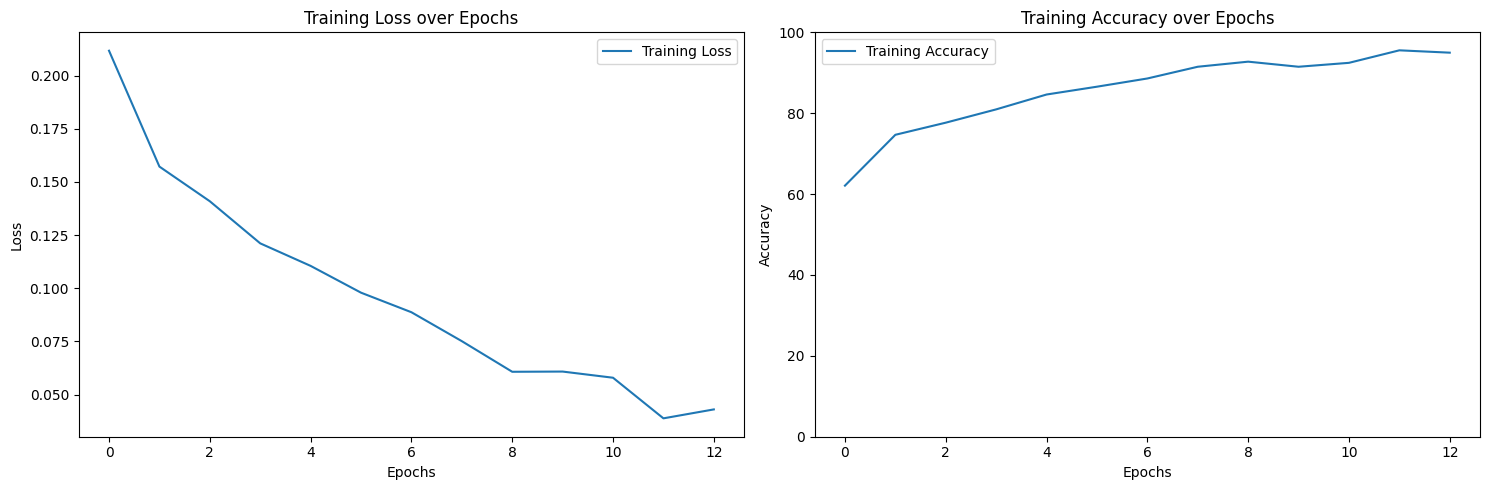

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()